# Оценка токсичности комментариев

## Описание проекта

Интернет-магазин «Викишоп» запускает новый сервис.
Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах.\
То есть клиенты предлагают свои правки и комментируют изменения других.\
Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.\
В распоряжении набор данных с разметкой о токсичности правок.

## Задача:

- Обучить модель классифицировать комментарии на позитивные и негативные.
- Построить модель со значением метрики качества F1 не меньше 0.75. 

## 1. Загрузка данных

### 1.1 Импорт необходимых для работы библиотек, метрик и утилит

In [1]:
# !pip install spacy && python -m spacy download en_core_web_sm

In [2]:
# импорт библиотек
import pandas as pd
import numpy as np
import nltk
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from nltk.corpus import wordnet
from nltk.corpus import stopwords as nltk_stopwords

# импорт моделей
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer


# кроссвалидация
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)

# метрики
from sklearn.metrics import f1_score

# настройки
import time
from tqdm.notebook import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")
from pylab import rcParams
nltk.download('wordnet')

# константа верхний регистр
RANDOM_STATE = 42

C:\Users\Mikhail\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mikhail\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### 1.2 Загрузим данные

In [3]:
# загрузим данные
data_text = pd.read_csv('C:\\Users\\Mikhail\\Яндекс_Практикум\\data_set\\toxic_comments.csv')

In [4]:
data_text.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
# функция для получения общей информации о данных
def get_info(data):
    display(data.head())
    display(data.tail())
    data.info()
    print('\nРазмер таблицы:', data.shape)
    print('\nКоличество явных дубликатов:', data.duplicated().sum())
    print('\nКоличество пропусков в таблице:', data.isna().sum().sum())

In [6]:
get_info(data_text)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


,Unnamed: 0,text,toxic
159287,159446,""":::::And for the second time of asking, when ...",0
159288,159447,You should be ashamed of yourself \n\nThat is ...,0
159289,159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159290,159449,And it looks like it was actually you who put ...,0
159291,159450,"""\nAnd ... I really don't think you understand...",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB

Размер таблицы: (159292, 3)

Количество явных дубликатов: 0

Количество пропусков в таблице: 0


### 1.3 Описание данных

- **text - содержит текст комментария**
- **toxic - целевой признак**

In [7]:
# удалим признак Unnamed: 0, так он не понадобится для обучения модели, сохраним данные в новый датафрейм
df = data_text.drop(['Unnamed: 0'],axis = 1)

In [8]:
# оценим распределение уникальных значений в целевом признаке
class_frequency = df['toxic'].value_counts(normalize= True).to_frame()
print(class_frequency)

      toxic
0  0.898388
1  0.101612


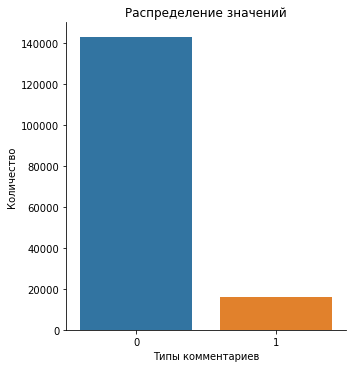

In [9]:
# посмотрим на графике
sns.catplot(data=df, x="toxic",  kind="count")

plt.title('Распределение значений')
plt.xlabel('Типы комментариев')
plt.ylabel('Количество');

### Выводы

* Дубликаты и пропуски не выявлены
* Удален избыточный признак 'Unnamed: 0'
* Целевой признак не сбалансирован

## 2. Подготовка данных

### 2.1 Очистка и лемматизация текста

In [10]:
# cоздадим корпус 
corpus = list(df['text'])

In [11]:
# загрузим языковую модель для SpaCy
nlp = spacy.load('en_core_web_sm')

# функция лемматизирует английский текст, используем SpaCy
def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_tokens = []
    for token in doc:
        if token.is_alpha and not token.is_stop:
            lemma = token.lemma_.lower()
            lemmatized_tokens.append(lemma)
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

In [12]:
# функция удаляет символы, знаки и приводит текст в нижний регистр
def clear_text(text):
    cl_text = re.sub(r'(?:\n|\r)', ' ', text)
    cl_text = re.sub(r'[^a-zA-Z]', ' ', text)
    cl_text = cl_text.lower()
    cl_text = ' '.join(cl_text.split())
    return cl_text

# проверка работы функции
print('\033[1m'+"Исходный текст:"+'\033[0m', corpus[0])
print('='*180)
print('\033[1m'+"Очищенный и лемматизированный текст:"+'\033[0m', lemmatize_text(clear_text(corpus[0])))

Исходный текст: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Очищенный и лемматизированный текст: explanation edit username hardcore metallica fan revert weren t vandalism closure gas vote new york dolls fac don t remove template talk page m retire


In [13]:
# добавим готовый текст в новый столбец для сравнения
df['lemmatized_text'] = df['text'].progress_apply(lemmatize_text)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [14]:
# оценим результат
display(df.head())
display(df.tail())

,text,toxic,lemmatized_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edit username hardcore metallica f...
1,D'aww! He matches this background colour I'm s...,0,match background colour seemingly stick thank ...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man try edit war guy constantly remove rel...
3,"""\nMore\nI can't make any real suggestions on ...",0,real suggestion improvement wonder section sta...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page


,text,toxic,lemmatized_text
159287,""":::::And for the second time of asking, when ...",0,second time asking view completely contradict ...
159288,You should be ashamed of yourself \n\nThat is ...,0,ashamed horrible thing talk page
159289,"Spitzer \n\nUmm, theres no actual article for ...",0,spitzer umm s actual article prostitution ring...
159290,And it looks like it was actually you who put ...,0,look like actually speedy version delete look
159291,"""\nAnd ... I really don't think you understand...",0,think understand come idea bad right away kind...


### 2.2 Разделим выборки и извлечем признаки
* **train** - обучающая выборка (**90%** исходных данных)
* **test** - тестовая выборка (**10%** исходных данных)

In [15]:
features = df['lemmatized_text']                    # признаки
target = df['toxic']                                # целевой признак

In [16]:
# разделим на тренировочную - 90% и тест - 10% выборки и сохраним соотношение классов
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.1, random_state=RANDOM_STATE, stratify=target)

In [17]:
print('\033[1m'+ 'Обучающая выборка'+'\033[0m')
print ('Признаки:',X_train.shape, '\n', 'Целевой признак:', y_train.shape, sep='')
print('='*30)
print('\033[1m'+ 'Тестовая выборка'+'\033[0m')
print ('Признаки:',X_test.shape, '\n', 'Целевой признак:', y_test.shape, sep='')

Обучающая выборка
Признаки:(143362,)
Целевой признак:(143362,)
Тестовая выборка
Признаки:(15930,)
Целевой признак:(15930,)


In [18]:
# определим английские стоп слова и передадим их счетчик
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mikhail\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
%%time
# оценим частоту использования и важность слов
# переведем выборки признаков в векторы
#count_tf_idf = TfidfVectorizer(stop_words=stopwords)
#tf_idf_X_train = count_tf_idf.fit_transform(X_train)
#tf_idf_X_test = count_tf_idf.transform(X_test)

CPU times: total: 0 ns
Wall time: 0 ns


### Выводы

* Слова приведены к начальным формам, удалены символы и стоп-слова
* Выборки разделены на трейн, валид и тест; признаки извлечены
* Проведена оценка частоты и важности слов, выборки преобразованы в векторы

## 3. Исследуем модели

* RandomForest Classifier
* DecisionTree Classifier
* Logistic Regression

Для каждой подберем гиперпараметры и оценку лучшей модели на валидационной выборке.

### 3.1 Модель "RandomForest Classifier"

In [20]:
# признаки для RandomForest
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [21]:
# создадим пайплайн
pipeline_rf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('rfc', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

In [22]:
# определим гиперпараметры
parametrs_rf = {'rfc__n_estimators': [50, 251, 50],
    'rfc__max_depth': [2, 15],
    'rfc__min_samples_split': [2, 3, 4],
    'rfc__min_samples_leaf': [1, 2, 3, 4]
}

In [23]:
start_time = time.time()
rf = RandomizedSearchCV(pipeline_rf, parametrs_rf, cv=5, n_jobs=-1, scoring='f1')
for _ in tqdm(range(10)):
    rf.fit(X_train_rf, y_train)
end_time = time.time()

f1_rf_train = rf.best_score_
best_rf = rf.best_estimator_

# результаты
print('\033[1m'+ 'Модель "RandomForest Classifier"'+'\033[0m')
print('\033[1m'+'f1:'+'\033[0m', f1_rf_train)
print('='*75)
print("Лучшие параметры для RandomForest Classifier: \n", rf.best_params_)
print('='*75)
print("Время выполнения: ", end_time - start_time)

  0%|          | 0/10 [00:00<?, ?it/s]

Модель "RandomForest Classifier"
f1: 0.3930638510231873
Лучшие параметры для RandomForest Classifier: 
 {'rfc__n_estimators': 251, 'rfc__min_samples_split': 4, 'rfc__min_samples_leaf': 2, 'rfc__max_depth': 15}
Время выполнения:  1809.8463995456696


### 3.2 Модель "DecisionTree Classifier"

In [24]:
# признаки для DecisionTree
X_train_dt = X_train.copy()
X_test_dt = X_test.copy()

In [25]:
# создадим пайплайн
pipeline_dt = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

In [26]:
# зададим параметры для подбора в GridSearchCV
parametrs_dt = {
    'clf__max_depth': [10, 20, 30, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

In [33]:
%%time
# подберем лучшие параметры для модели RandomForest
dt = GridSearchCV(
    pipeline_dt, 
    param_grid=parametrs_dt,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

dt.fit(X_train, y_train)

f1_dt_train = dt.best_score_
best_dt = dt.best_estimator_

print('\033[1m'+ 'Модель "DecisionTree Classifier"'+'\033[0m')
print('\033[1m'+'f1:'+'\033[0m', f1_dt_train)
print('='*75)
print("Лучшие параметры для DecisionTree Classifier:\n", dt.best_params_)
print('='*75)

Модель "DecisionTree Classifier"
f1: 0.6646152135118037
Лучшие параметры для DecisionTree Classifier:
 {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
CPU times: total: 3min 14s
Wall time: 39min 3s


### 2.5 Модель "Logistic Regression"

In [34]:
# признаки для Logistic Regression
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()

In [35]:
# создадим пайплайн
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words=stopwords)),
    ('clf', LogisticRegression(solver='newton-cg', random_state=RANDOM_STATE, class_weight='balanced', max_iter=1000))
])

In [36]:
# определим параметры для подбора в GridSearchCV
parametrs_lr = {
    'clf__C': [1, 15, 3],
    'clf__penalty': ['l1', 'l2']
}

In [37]:
%%time
# передаем модель, параметры и оценку в GridSearchCV
lr  = GridSearchCV(
    pipeline_lr,
    param_grid=parametrs_lr,
    cv=5,
    verbose=True,
    n_jobs=-1,
    scoring='f1'
)
# обучим на тренировочных данных
lr.fit(X_train, y_train)

# найдем лучший f1
f1_lr_train = lr.best_score_
best_lr = lr.best_estimator_

print('\033[1m'+ 'Модель "Logistic Regression"'+'\033[0m')
print('\033[1m'+'f1:'+'\033[0m', f1_lr_train)
print('='*75)
print("Лучшие параметры для Logistic Regression: \n", lr.best_params_)
print('='*75)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Модель "Logistic Regression"
f1: 0.7575530484548796
Лучшие параметры для Logistic Regression: 
 {'clf__C': 3, 'clf__penalty': 'l2'}
CPU times: total: 29.3 s
Wall time: 54.8 s


## 4. Результаты моделей на обучающей выборке

In [38]:
# таблица f1 моделей на обучающей выборке
index_result =['LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier']
data_result = {'f1 на обучающей выборке':[f1_lr_train, f1_dt_train, f1_rf_train]}

result = pd.DataFrame(data=data_result, index=index_result)
result

,f1 на обучающей выборке
LogisticRegression,0.757553
DecisionTreeClassifier,0.664615
RandomForestClassifier,0.393064


## 5. Проверка лучшей модели

### 5.1 Получим предсказание f1 для тестовой выборки

In [39]:
# предсказания лучшей модели Linear Regression
pred_test_lr = best_lr.predict(X_test_lr)

f1_lr_test = f1_score(y_test, pred_test_lr)

print('\033[1m'+ 'Модель "Linear Regression"'+'\033[0m')
print('\033[1m'+'f1:'+'\033[0m', f1_lr_test)
print('='*30)

Модель "Linear Regression"
f1: 0.7646730016769144


## Вывод

1. Загруженны и изученны исходные данные:
* получены данные со 159292 комментариями с разметкой о токсичности;
* пропуски и дубликаты в данных не обнаружены;
* удален избыточный признак 'Unnamed: 0'; 
* выявлено, что целевой признак не сбалансирован.

2. Проведена подготовка данных:
* текст комментариев переведен в нижний регистр, очищен от символов;
* слова приведены к начальным формамм (лемматизированы);
* удалены стоп-слова.

3. Данные подготовлены к обучению, разделеные на выборки:
* выборки разделены на обучающую, тестовую в соотношении 9:1
* проведена оценка частоты и важности слов, 
* выборки преобразованы в векторы.

4. Были изучены три модели, подобраны гиперпараметры на обучающей выборке:
* модель с лучшим показателем f1 - Linear Regression 
* на трейне - 0.7575

5. Окончательная проверка лучшей модели проведена на тестовой выборке:
* f1 модели Linear Regression = 0.7646
* достигнут целевой результат f1 > 0.75